### Outline

We will built a Neural Network along with its Architecture by including all the Parameters, Hyperpapameters like Learning Rate, Loss Functions, Optimisation Algorithms, Loss Functions, Activation Functions etc....

The NN Model is built for a "Classification" problem statement.

### Importing Libraries

Importing Libraries and Setting required configurations

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [0]:
np.random.seed(0)

### Generating Data for Classification Problem

In [0]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


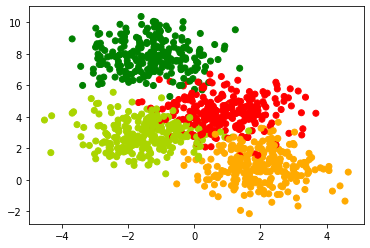

In [0]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

It can be done into a binary classification probelm in many ways. The following is one of the way.

In [0]:
labels_orig = labels
labels = np.mod(labels_orig, 4)

Data Pre-Processing

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [0]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


### Creating a Neural Network

In [0]:
class NN:

    def __init__(self,init_method,layer_sizes,optimiser,loss,activation_function,leaky_slope=0.01):

        self.params = {}
        self.gradients = {}
        self.params_h = []
        self.layer_sizes = layer_sizes
        self.num_layers=3                                                       # This NN is created for 2 Hidden Layered Neural Networks
        self.optimiser = optimiser
        self.loss  = loss
        self.activation_function = activation_function
        self.leaky_slope = leaky_slope
        self.update_params={}
        self.prev_update_params={}

        # Different Initialzation Methods and Initialization of Updatable parameters.

        if init_method == 'random':
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])
                self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])

        if init_method == 'zeros':
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)] = np.zeros((self.layer_sizes[i-1],self.layer_sizes[i]))
                self.params["B"+str(i)] = np.zeros((1,self.layer_sizes[i]))

        if init_method == 'xavier':
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i]) * np.sqrt(1/self.layer_sizes[i-1])
                self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])

        if init_method == 'he':
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i]) * np.sqrt(2/self.layer_sizes[i-1])
                self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])


        for i in range(1,self.num_layers+1):                                    # These parameters will be used in Optimiser
            self.update_params["v_w"+str(i)]=0
            self.update_params["v_b"+str(i)]=0
            self.update_params["m_b"+str(i)]=0
            self.update_params["m_w"+str(i)]=0
            self.prev_update_params["v_w"+str(i)]=0
            self.prev_update_params["v_b"+str(i)]=0

        
    def forward_activation(self,X):                                             # Activation Functions
        if self.activation_function == 'sigmoid':
            return 1.0/(1.0 + np.exp(-X))
        elif self.activation_function == 'tanh':
            return np.tanh(X)
        elif self.activation_function == 'relu':
            return np.maximum(0,X)
        elif self.activation_function == 'leaky_relu':
            return np.maximum(self.leaky_slope*X,X)


    def softmax(self,X):                                                        # Softmax Function
        return np.exp(X)/(np.sum(np.exp(X), axis=1).reshape(-1,1))


    def grad_activation(self,X):                                                # Gradient of Activation Functions
        if self.activation_function == 'sigmoid':
            return X*(1-X)
        elif self.activation_function == 'tanh':
            return (1-np.square(X))
        elif self.activation_function == 'relu':
            return 1.0*(X>0)
        elif self.activation_function == 'leaky_relu':
            d=np.zeros_like(X)
            d[X<=0]=self.leaky_slope
            d[X>0]=1
            return d


    def forward_propagation(self,X,params=None):                                # Forward Propagation of NN

        if params is None:
            params = self.params

        self.A1 = np.matmul(X, params["W1"]) + params["B1"]                     
        self.H1 = self.forward_activation(self.A1)                              
        self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"]               
        self.H2 = self.forward_activation(self.A2)
        self.A3 = np.matmul(self.H2, params["W3"]) + params["B3"]               
        self.H3 = self.softmax(self.A3)

        return self.H3


    def grad(self,X,Y,params=None):                                             # Gradients of Parameters

        if params is None:
            params = self.params

        
        self.forward_propagation(X, params)                                     # Forward propagation is done and corresponding gradients are updated
        m = X.shape[0]
        self.gradients["dA3"] = self.H3 - Y
        self.gradients["dW3"] = np.matmul(self.H2.T, self.gradients["dA3"])
        self.gradients["dB3"] = np.sum(self.gradients["dA3"], axis=0).reshape(1, -1)
        
        self.gradients["dH2"] = np.matmul(self.gradients["dA3"], params["W3"].T)
        self.gradients["dA2"] = np.multiply(self.gradients["dH2"], self.grad_activation(self.H2))
        self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"])
        self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1)

        self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T)
        self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1))
        self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"])
        self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1)

        

    def predict(self,X):
        Y_pred = self.forward_propagation(X)
        return np.array(Y_pred).squeeze()


    def fit(self,X,Y,epochs=10,mini_batch_size=64,learning_rate=0.5,beta=0.9,beta1=0.9,beta2=0.9,gamma=0.9,eps=1e-8,display_loss=True):

        if display_loss:
            loss = {}
            Y_pred = self.predict(X)
            if self.loss == 'MSE':
                loss[0] = mean_squared_error(Y,Y_pred)
            elif self.loss == 'log_loss':
                loss[0] = log_loss(np.argmax(Y,axis=1),Y_pred)

        
        for num_epoch in tqdm_notebook(range(epochs),total=epochs,unit='epoch'):
            m = X.shape[0]

            if self.optimiser == 'GD':
                self.grad(X, Y)
                for i in range(1,self.num_layers+1):
                    self.params["W"+str(i)] -= learning_rate * (self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= learning_rate * (self.gradients["dB"+str(i)]/m)

            elif self.optimiser == 'MiniBatch':     
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                    for i in range(1,self.num_layers+1):
                        self.params["W"+str(i)] -= learning_rate * (self.gradients["dW"+str(i)]/mini_batch_size)
                        self.params["B"+str(i)] -= learning_rate * (self.gradients["dB"+str(i)]/mini_batch)

            elif self.optimiser == 'Momentum':
                self.grad(X, Y)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] = gamma*self.update_params["v_w"+str(i)] + learning_rate * (self.gradients["dW"+str(i)]/m)
                    self.update_params["v_b"+str(i)] = gamma*self.update_params["v_b"+str(i)] + learning_rate * (self.gradients["dB"+str(i)]/m)
                    self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
                    self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]

            elif self.optimiser == 'NGD':
                temp_params = {}
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
                    self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
                    temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
                    temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
                self.grad(X,Y,temp_params)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + learning_rate * (self.gradients["dW"+str(i)]/m)
                    self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + learning_rate * (self.gradients["dB"+str(i)]/m)
                    self.params["W"+str(i)] -= learning_rate * (self.update_params["v_w"+str(i)])
                    self.params["B"+str(i)] -= learning_rate * (self.update_params["v_b"+str(i)]) 
                self.prev_update_params=self.update_params

            elif self.optimiser == "AdaGrad":
                self.grad(X, Y)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
                    self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
                    self.params["W"+str(i)] -= (learning_rate/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= (learning_rate/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
        
            elif self.optimiser == "RMSProp":
                self.grad(X, Y)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
                    self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
                    self.params["W"+str(i)] -= (learning_rate/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= (learning_rate/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
                
            elif self.optimiser == "Adam":
                self.grad(X, Y)
                num_updates=0
                for i in range(1,self.num_layers+1):
                    num_updates+=1
                    self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
                    self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
                    m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
                    v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
                    self.params["W"+str(i)] -=(learning_rate/np.sqrt(v_w_hat+eps))*m_w_hat
                    
                    self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
                    self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
                    m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
                    v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
                    self.params["B"+str(i)] -=(learning_rate/np.sqrt(v_b_hat+eps))*m_b_hat

            if display_loss:
                Y_pred = self.predict(X)
                if self.loss == 'MSE':
                    loss[num_epoch+1] = mean_squared_error(Y,Y_pred)
                    self.params_h.append(np.concatenate((self.params['W1'].ravel(), self.params['W2'].ravel(),self.params['W3'].ravel(), self.params['B1'].ravel(), self.params['B2'].ravel(), self.params['B3'].ravel())))
                elif self.loss == 'log_loss':
                    loss[num_epoch+1] = log_loss(np.argmax(Y,axis=1),Y_pred)
                    self.params_h.append(np.concatenate((self.params['W1'].ravel(), self.params['W2'].ravel(),self.params['W3'].ravel(), self.params['B1'].ravel(), self.params['B2'].ravel(), self.params['B3'].ravel())))
        if display_loss:
            plt.plot(np.array(list(loss.values())), '-o', markersize=3)
            plt.xlabel('Epochs')
            plt.ylabel('Loss: ' + self.loss)
            plt.show()      

In [0]:
def post_process(scatter_plot=False, gradient_plot=True, plot_scale=0.1):    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))    
    
    if scatter_plot:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()
    
    
    if gradient_plot:
      h = np.asarray(model.params_h)
      h_diff = (h[0:-1, :] - h[1:, :])
      for i in range(24):
        plt.subplot(8, 3, i+1)
        plt.plot(h_diff[:, i], '-')
        plt.ylim((-plot_scale, plot_scale))
        plt.yticks([])
        plt.xticks([])
      plt.show()

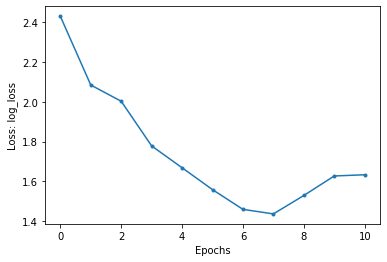

Training accuracy 0.2493
Validation accuracy 0.252


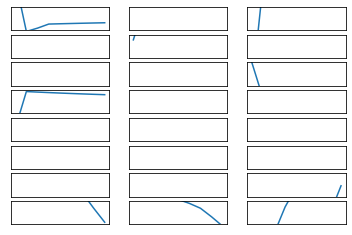

In [0]:
model = NN(init_method='xavier',layer_sizes=[2,2,2,4],optimiser='Adam',loss = 'log_loss',activation_function='relu')
model.fit(X_train, y_OH_train)
post_process()